# PS2: Future Share Price Prediction using a Trinomial Lattice Model
__Congratulations!__ You have been awarded a contract to develop a trinomial lattice model to simulate future equity share prices. In this model, at each step, the future share price can transition to an `up`-state, a `down`-state, or stay the same in the `unch`-state. The model will use a real-world probability measure to estimate the probability of moving to each future state and the magnitude of that move.

Some starter code has been provided in the `src` folder of this project, but you'll need to implement a few methods in the [src/Student.jl file](src/Student.jl). If you get stuck, the teaching team has provided a reference for the implementation of your methods in the [soln/Student.jl file](soln/Student.jl)

## Setup
Set up the computational environment using [the `Include.jl` file](Include.jl). The [`Include.jl` file](Include.jl) loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). This problem set __does not depend__ upon [the VLQuantitativeFinancePackage.jl package](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [3]:
include("Include.jl");

In [4]:
include(joinpath(_PATH_TO_SOLN, "Student.jl")); # load the missing functions from soln

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_training_dataset` by calling [the `MyTrainingMarketPriceDataSet()` function](src/Files.jl):

In [6]:
original_training_dataset = MyTrainingMarketPriceDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [8]:
maximum_number_trading_days = original_training_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `training)dataset::Dict{String,DataFrame}` variable:

In [10]:
training_dataset = Dict{String,DataFrame}();
for (ticker,data) ‚àà original_training_dataset
    if (nrow(data) == maximum_number_trading_days)
        training_dataset[ticker] = data;
    end
end
training_dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508√ó8 DataFrame‚Ä¶
  "EMR"  => 1508√ó8 DataFrame‚Ä¶
  "CTAS" => 1508√ó8 DataFrame‚Ä¶
  "HSIC" => 1508√ó8 DataFrame‚Ä¶
  "KIM"  => 1508√ó8 DataFrame‚Ä¶
  "PLD"  => 1508√ó8 DataFrame‚Ä¶
  "IEX"  => 1508√ó8 DataFrame‚Ä¶
  "BAC"  => 1508√ó8 DataFrame‚Ä¶
  "CBOE" => 1508√ó8 DataFrame‚Ä¶
  "EXR"  => 1508√ó8 DataFrame‚Ä¶
  "NCLH" => 1508√ó8 DataFrame‚Ä¶
  "CVS"  => 1508√ó8 DataFrame‚Ä¶
  "DRI"  => 1508√ó8 DataFrame‚Ä¶
  "DTE"  => 1508√ó8 DataFrame‚Ä¶
  "ZION" => 1508√ó8 DataFrame‚Ä¶
  "AVY"  => 1508√ó8 DataFrame‚Ä¶
  "EW"   => 1508√ó8 DataFrame‚Ä¶
  "EA"   => 1508√ó8 DataFrame‚Ä¶
  "NWSA" => 1508√ó8 DataFrame‚Ä¶
  "CAG"  => 1508√ó8 DataFrame‚Ä¶
  "GPC"  => 1508√ó8 DataFrame‚Ä¶
  "FCX"  => 1508√ó8 DataFrame‚Ä¶
  "GILD" => 1508√ó8 DataFrame‚Ä¶
  "UNP"  => 1508√ó8 DataFrame‚Ä¶
  "CDW"  => 1508√ó8 DataFrame‚Ä¶
  ‚ãÆ      => ‚ãÆ

Next, get a list of ticker symbols for the firms in the cleaned-up `training_dataset` and save it in the `list_of_all_tickers::Array{String,1}` array. We sort the list of ticker symbols alphabetically using [the build-in Julia `sort(...)` function](https://docs.julialang.org/en/v1/base/sort/#Base.sort).
* _What is the `|>`_? This is the [Julia pipe (function composition) operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). It takes the result of its left-hand operon and inserts it into its right-hand side operon. So the statement below is: we get [the keys of the dictionary](https://docs.julialang.org/en/v1/base/collections/#Base.keys), turn that into an array using [the collect method](https://docs.julialang.org/en/v1/base/collections/#Base.collect-Tuple{Type,%20Any}), and sort it [using the `sort(...)` method](https://docs.julialang.org/en/v1/base/sort/#Base.sort). We then save the result in the `list_of_all_tickers` variable.

In [12]:
list_of_all_tickers = keys(training_dataset) |> collect |> sort;

#### Constants
Finally, set some constants we'll use later in this notebook. The comments describe the constants, the units, permissible values, etc.

In [14]:
Œît = (1/252); # 1-trading day in units of years
œµ = 0.05; # region around zero to classify as unch => 0 ¬± œµ will be counted as unch

## Task 1: Estimate the real-world lattice parameters from data
In this task, we'll estimate the parameters of the trinomial lattice model using a real-world probability measure, i.e., from growth rate data. We'll start by explaining the parameters of a trinomial model; we'll then calculate the growth rate for a ticker of interest, in this case, `SPY,` and then we'll estimate the trinomial model parameters.

### Parameters
A trinomial model has five parameters to estimate $(p,\bar{p},q,u,d)$, and a hyper-parameter $\epsilon$ (the distance around that we define as an `unch` move) that we select.
* The up factor $u$ and the down factor $d$ are the same as the binomial model. The up parameter $u$ is the amount the share increases over a period if we transition to the `up`-state. Likewise, the down factor $d$ is the amount the share price decreases if we transition to the `down`-state.
* For a trinomial model, we have _three probability parameters_ $(p,\bar{p},q)$ that we have to estimate. The parameter $p$ denotes the probability of a `up`-move, $\bar{p}$ denotes the probability of a `down`-move, and $q$ denote the probability of an `unch` move. Because we have three outcomes: $q = 1 - p - \bar{p}$.
* _Aside_: To be technical, the $(p,\bar{p},q)$ are the parameters of [a categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution), which we could theoretically sample at each node of the tree to determine the next state. A [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) is a generalization of [the Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), which we used in the binomial case.

Given a value for $\epsilon$, we can estimate values for $(p,\bar{p},q,u,d)$ using logic similar to the binomial case, i.e., we count the number of up-days and divide by the total number of days to get $p$, etc.

### Estimate the growth rate array
Now that we have loaded the data, we can calculate the growth rate. We assume a share price model of the form:
$$
S_{j} = \exp\left(\mu_{j,j-1}\cdot\Delta{t}\right)\cdot{S_{j-1}}
$$
where $\mu_{j,j-1}$ denotes the _growth rate_ (units: 1/time) and $\Delta{t}$ (units: time) denotes the time step during the period $(j-1)\rightarrow{j}$. Solving for the growth parameter $\mu_{j,j-1}$ gives the expression:
$$
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{j}}{S_{j-1}}\right)
$$
We use daily data; thus, the natural time frame between $S_{j-1}$ and $S_{j}$ is a single day. However, it will be easier to use an annualized value for the $\mu$ parameter; thus, we let $\Delta{t} = 1/252$, i.e., the fraction of a year that occurs in a single trading day.
* The [`log_growth_matrix(...)` method](src/Student.jl) takes `dataset` $\mathcal{D}$ and a list of firms $\mathcal{L}$ and computes the growth rate values for each firm as a function of time. The data is returned as a $\mathcal{D}_{i}\times\dim\mathcal{L}$ array (time on the rows, firm $i$ on the columns). We store the data in the `log_growth_array::Array{Float64,1}` variable.
* __TODO__: Finish the implementation of the [`log_growth_matrix(...)` method](src/Student.jl) in `src/Student.jl.` For clues, [check out the `VLQuantativeFinancePackage.jl` implementation of this method](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl/blob/e9a3f416dac2722b7c13aaeff23637fc40bdd68a/src/Base.jl#L2-L28). Alternatively, we've provided an implementation in the `soln` directory if you get stuck.

In [17]:
log_growth_array = log_growth_matrix(training_dataset,  list_of_all_tickers, Œît = Œît);

* This study will focus on [the SP500 ETF `SPY`](https://finance.yahoo.com/quote/SPY/). Set the `ticker_to_analyze::String` variable to `SPY.` We'll then look up the location (index) of `SPY` in the `list_of_all_tickers` using [the `findfirst(...)` method](https://docs.julialang.org/en/v1/base/arrays/#Base.findfirst-Tuple{Function,%20Any}), and save it to the `i` variable.

In [19]:
ticker_to_analyze = "SPY";
i = findfirst(ticker -> ticker == ticker_to_analyze, list_of_all_tickers);

Using the `log_growth_array::Array{Float64,2},` estimate the $(p,\bar{p},q,u,d)$ parameters assuming a real-world probability measure by passing the growth-rate data to [a `RealWorldTrinomialProbabilityMeasure` instance](src/Types.jl), which returns [a `MyRealWorldTrinomialSharePriceTreeParameters` instance](src/Types.jl) which holds the parameters.
* __TODO__: behind the scenes, this call points to a private function that computes the $(p,\bar{p},q,u,d)$ by analyzing the $\mu$-time series data in the `log_growth_array::Array{Float64,1}` variable. You'll need to provide the implementation of that private method in the [`src/Student.jl` file](src/Student.jl). Look at the [bionomial implementation in the VLQuantativeFinancePackage.jl for clues](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl/blob/e9a3f416dac2722b7c13aaeff23637fc40bdd68a/src/Compute.jl#L360). Alternatively, the answer is included in the `soln` directory (but that's not exciting!)

In [21]:
parameters = (RealWorldTrinomialProbabilityMeasure())(log_growth_array[:,i], œµ = œµ);

In [22]:
typeof(parameters)

MyRealWorldTrinomialSharePriceTreeParameters

### Check: Do the estimated probabilities sum to `1`?
The calculation of the $(p,\bar{p},q,u,d)$ parameters does not use the $q = 1 - p - \bar{p}$ expression, i.e., it estimates $p$, $\bar{p}$ and $q$ independently. If your calculation is correct, then $p + \bar{p} + q = 1$. 
* Write a check [using the @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to verify $p + \bar{p} + q = 1$.

In [24]:
let 
    p = parameters.p; # get p from parameters
    pÃÑ = parameters.pÃÑ; # get pÃÑ from parameters
    q = parameters.q; # get q from parameters
    @assert (p + pÃÑ + q) == 1
end

## Task 2: Build a trinomial model and test in-sample performance
In this task, we'll use the parameters from the previous task to construct [a `MyAdjacencyBasedTrinomialSharePriceTreeModel` instance](src/Types.jl) using [a custom `build(...)` method](src/Factory.jl) and then we'll simulate the future share price distribution for `SPY` by calling [the `populate(...)` method](src/Student.jl). This will compute the price and probability values for all the nodes in the tree for each level (time slice) of the tree.

Let's begin by setting the number of levels (time slices) in the tree by specifying the `h::Int64` parameter. For this study, let `h = 13`.

In [26]:
h = 13; # will give h + 1 levels with index {0,1,...,h-1} because zero-based

Select a (random) `h-day` period by setting the `random_start_index::Int64` variable. Here, we'll specify the start index (the trading day index from which we initialize the simulation) to `1321`.

In [28]:
random_start_index = 1321; # this is where we will start
random_stop_index = random_start_index + (h - 1);

Now that we have the time range of the simulation, let's grab the initial share price for the simulation from the `original_training_dataset::DataFrame,` save this value to the `S‚Çí::Float64` variable

In [30]:
S‚Çí = original_training_dataset[ticker_to_analyze][random_start_index, :volume_weighted_average_price];

### Build the tree, simulate the future share prices
Finally, let's build and save the tree model in the `latticemodel::MyAdjacencyBasedTrinomialSharePriceTreeModel` variable. This is a two-step process. 
* First, we make an empty tree using [the `build(...)` method for `MyAdjacencyBasedTrinomialSharePriceTreeModel`](src/Factory.jl), where we pass in the type of thing we want to build, i.e., a `MyAdjacencyBasedTrinomialSharePriceTreeModel` instance and the data needed to build it, i.e., the `parameters::MyRealWorldTrinomialSharePriceTreeParameters` we estimated above.
* Second, we populate the tree [using the `populate(...)` method](src/Student.jl). This method computes the price and the probability of each node, [which is a multinomial distribution instead of a binomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution), as well as some other data such as the connectivity of the tree (how the nodes are connected). The [`populate(...)` method](src/Student.jl) takes the initial share price `S‚Çí` and the height of the tree (zero-based) in the `h` argument.
* __Challenge problem (optional)__: The current tree implementation in `src/Student.jl` is a full `3-tree`. However, we know this should be a recombining tree _not_ a full tree. The practical significance is that we are limited in the number of future days we can simulate because the number of tree nodes increases quickly. Develop a refactored [`populate(...)` method](src/Student.jl) that constructs a recombining tree instead of a full tree. The recombined tree should have the correct price, probability, connectivity, and levels data.

In [32]:
latticemodel = build(MyAdjacencyBasedTrinomialSharePriceTreeModel, parameters) |> model -> populate(model, S‚Çí = S‚Çí, h = h);

#### Visualize price distribution at tree level `h`
Let's quickly check to ensure we are getting what we expect. For a full `k`-tree (where `k = 3` in this case), we expect there will be $k^{l}$ nodes in the tree at level `l.`  For example, at `l = 2`, we should see nine nodes with price, probability, and path (the path to get to that node from the root) data.
* `Unhide` the code block below to see how we constructed a node table for `l = 2`.  From this table, we can see that our reference implementation of [the `populate(...)` method](src/Student.jl) produces a tree with duplicate nodes, i.e., `[a,b]` and `[b,a].`
* For a more sophisticated implementation (the challenge problem above), we should eliminate these nodes and update the connectivity and levels dictionaries. However, the reference implementation will work for now. 

In [34]:
let
    l = 2; # test level of the tree
    nodeid = latticemodel.levels[l]
    df = DataFrame();
    counter = 1;
    for i ‚àà nodeid
        node = latticemodel.data[i];
        
        row_df = (
            count = counter,
            index = i,
            probability = node.probability,
            price = node.price,
            path = node.path,
        );
        push!(df, row_df);
        counter += 1
    end
    pretty_table(df, tf = tf_simple)
end

======== ======= ============= ========= ===============
  count   index   probability     price           path 
  Int64   Int64       Float64   Float64   Vector{Char} 
======== ======= ============= ========= ===============
      1       4      0.294632    413.33     ['a', 'a']
      2       5      0.030976   411.682     ['a', 'b']
      3       6       0.46536   410.064     ['a', 'c']
      4       7      0.030976   411.682     ['b', 'a']
      5       8   0.000814161   410.041     ['b', 'b']
      6       9     0.0244627   408.429     ['b', 'c']
      7      10       0.46536   410.064     ['c', 'a']
      8      11     0.0244627   408.429     ['c', 'b']
      9      12      0.183755   406.824     ['c', 'c']
======== ======= ============= ========= ===============


#### Check: verify the node price calculations
The path data on each node allows us to reproduce the path through the tree to get a node. The `a` is an up move, `b` is an unch move, and `c` is a down move. Let's recompute the prices on a few nodes to ensure our calculations are correct. 
* Write a check which [uses the @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) and [the `isapprox(...)` method](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) to verify the tree calculations for all nodes at level `l=2.` If the prices are correct, we pass the test; otherwise, [an AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) will be thrown.

In [36]:
let
    nodes = [4,5,6,7,8,9,10,11,12]; # nodes that we want to test at l = 2
    initialprice = S‚Çí; # the initial share price at the root of the tree

    computed_prices_tree = Array{Float64,1}(); # We'll put the prices computed in the tree here
    my_computed_prices = Array{Float64,1}(); # We'll put our computed prices here
    moves = Dict{Char,Float64}(); # this will hold the values for the moves

    # populate the computed_prices_tree array -
    for i ‚àà nodes
        push!(computed_prices_tree, latticemodel.data[i].price);
    end
    
    # populate the moves dictionary -
    moves['a'] = exp((parameters.u)*Œît); # up
    moves['b'] = 1.0; # unch
    moves['c'] = exp(-(parameters.d)*Œît); # down

    # process each node index in nodes array
    for i ‚àà nodes
        path = latticemodel.data[i].path;
        
        factor = 1.0;
        for m ‚àà path
            factor *= moves[m]
        end
        push!(my_computed_prices, initialprice*factor); # capture my computed prices
    end
    @assert isapprox(computed_prices_tree, my_computed_prices) == true # check
end

#### Check: Is the children's numbering correct?
We have connectivity information and data stored in the `latticemodel` instance, where the connectivity of the tree nodes is stored in the `connectivity::Dict{Int64, Array{Int64,1}}` field of the model. Let's compare this with the numbering we expect in the tree. For a full `k-tree` with `h`-levels, the indices of the children of node $i$, denoted by the set $\mathcal{C}_{i}$, are given by:
$$
\begin{equation}
\mathcal{C}_{i}=\left\{k\cdot{i}+1,k\cdot{i}+2,\dots,k\cdot{i}+k\right\}
\end{equation}
$$
`Unihde` the code block below to see how we checked the numbering of children nodes. Note: this check assumes a full `3`-tree. Thus, if you are brave and have refactored [the reference `populate(...)` method](src/Student.jl), you will need to update this test.

In [38]:
let
    k = 3; # branching factor
    h = 13; # the height of the tree
    i = 2; # parent node index

    # generate expected index set -
    expected_children = Array{Int64,1}(undef, 3);
    for c ‚àà 1:k
        expected_children[c] = k*i + c
    end
    @assert latticemodel.connectivity[i] == expected_children; # if not the same - boom.
end

#### Check: How many nodes do we have in the tree?
If this is a full `k-tree` with `h`-levels, we expect the tree will have:
$$
\begin{equation}
N_{h} = \sum_{j=0}^{h}k^j = \frac{k^{h+1}-1}{k-1}
\end{equation}
$$
nodes where $N_{h}$ includes the final layer of leaves. Let's check this condition using the `latticemodel` we constructed. The data for the nodes is stored in the `data` field; this should have $N_{h}$ entries in this dictionary.
* `Unhide` the code block below to see how we checked the number of nodes in the tree. Note: this check assumes a full `3`-tree. Thus, if you are brave and have refactored [the reference `populate(...)` method](src/Student.jl), you will need to update this test.

In [40]:
let
    k = 3; # branching factor
    h = 13; # the height of the tree (specified above)
    N‚Çï = (k^(h+1) - 1)/(k - 1); # expected number of nodes
    @assert N‚Çï == length(latticemodel.data); # We have a data entry for each node. Thus, the length(data) should be N‚Çï. Otherwise ... booom.
end

#### Check: Does the probability of _unique nodes_ on a level sum to `1`?
Finally, we've checked the prices, the size of the tree, and the children's labeling. The last thing we need to check is whether the probabilities at a given level `l` of the price tree sum to `1`.  The wrinkle, in this case, is that we have extra (duplicate) nodes produced by the reference implementation of [the `populate(...)` method](src/Student.jl). Thus, we need to do this probability check calculation using only _unique_ nodes.
* `Unihide` the code block below to see how we implemented the probability summation check for only _unique_ nodes. If your calculations are correct, this test should pass; otherwise, [and AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) will be thrown.

In [42]:
let
    L = h; # select a level of the tree to test, in this case let's look at the last level
    nodeid = latticemodel.levels[L]; # get the nodeids for level L
    probability_array = Array{Float64,1}(); # initialize some storage for the unique probabilities
    
    for i ‚àà nodeid # iterate through the nodeids
        node = latticemodel.data[i]; # get the node for id i
        
        probability = node.probability; # get the probability from the node model
        if ((probability ‚àà probability_array) == false) # do we already have this probability, or is this a duplicate node?
            push!(probability_array,probability); # unique node
        end
    end
    @assert sum(probability_array) ‚âà 1 # \approx function (fancy)
end;

### Visualize trinomial lattice simulation
Next, look at how the trinomial model simulations compare with market observations. In particular, we'll compute the expected value and the variance of the simulated price as a function of time, i.e., at each level in the tree using the local [`ùîº(...)`](src/Compute.jl) and [`Var(...)` functions](src/Compute.jl).
* The `levels` array holds the index of the tree levels, i.e., the time slices. The [`ùîº(...)`](src/Compute.jl) and [`Var(...)` functions](src/Compute.jl) take the `latticemodel` tree model, and the `levels` array and return the expectation and the variance, respectively. 

In [44]:
levels = [k for k ‚àà 0:(h-1)]
expectation = ùîº(latticemodel, levels); # compute the expected value
variance = Var(latticemodel, levels); # compute the variance

#### Summary
`Unhide` the code block below to see how we plotted the model simulations and the observed prices for a randomly selected firm using a binomial lattice model.
* The observed price (red and green lines) may or may not lie in the $\pm\,{z}\cdot\sigma$ confidence ranges, where `z = {1,1.96,2.576}` which are shown in progressively lighter shades of blue (depending upon the date range selected). The solid green line with circles is the [observed VWAP price](https://en.wikipedia.org/wiki/Volume-weighted_average_price), and the solid red line with circles is the close price for `SPY` in the date range simulated.

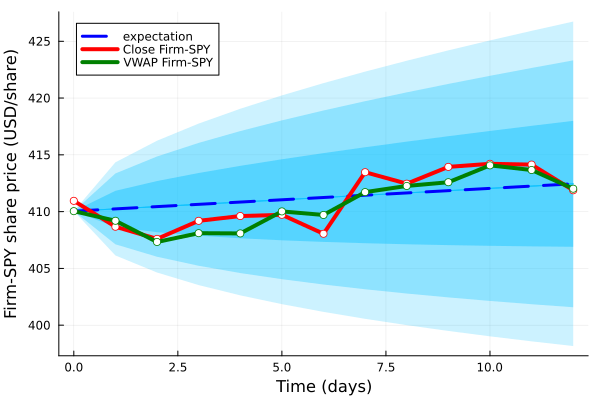

In [46]:
let 
    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])


    T_range = range(random_start_index,stop=random_stop_index,step=1) |> collect
    random_firm_data = original_training_dataset[ticker_to_analyze]
    key = :close
    
    plot(expectation[:,1], expectation[:,2], fillrange=L68, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U68, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L95, c=:deepskyblue1, alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U95, c=:deepskyblue1, alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L99, c=:deepskyblue1, alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U99, c=:deepskyblue1, alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], c=:blue, lw=3,ls=:dash, label="expectation")
    
    # data - close
    plot!(expectation[:,1], random_firm_data[T_range, key],  
        lw=4, c=:red, label="Close Firm-$(ticker_to_analyze)", legend = :topleft)
    scatter!(expectation[:,1], random_firm_data[T_range, key], label="", 
        msc=:red, mc=:white)

    # data - vwap
    plot!(expectation[:,1], random_firm_data[T_range, :volume_weighted_average_price],  
        lw=4, c=:green, label="VWAP Firm-$(ticker_to_analyze)", legend = :topleft)
    scatter!(expectation[:,1], random_firm_data[T_range, :volume_weighted_average_price], label="", 
        msc=:green, mc=:white)

    xlabel!("Time (days)", fontsize=18)
    ylabel!("Firm-$(ticker_to_analyze) share price (USD/share)", fontsize=18)
end

## Task 3: Was the simulation successful for the specified time range?
In this task, we will check the accuracy of the trinomial price projection for `SPY.` Determining if a model accurately represents data can be done in various ways, e.g., by looking at the stylized facts or calculating some other figure of merit. We'll do this later, but for now, let's think about this question purely in terms of the price prediction.

#### A simple functional test
We will utilize a simple, straightforward, functional test here. This test involves checking if the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$). 
* __Success__: If the simulation is bounded between $L_{j}$ and $U_{j}$ for $\forall{t}_{j}\in\mathcal{I}_{k}$, it is a `success.` The values for $L_{j}$ and $U_{j}$ can be customized, but we set these to $\mathbb{E}(X)\pm{2.576}\cdot{\sigma}$, where $\mathbb{E}(X)$ represents the expected share price value and $\sigma$ is the standard deviation of the lattice model simulation. 
* __Failure__: However, if the actual price exceeds the given bounds at any point, the simulation is considered a `failure.`

In [48]:
let

    # initialize -
    z = 2.576
    L = expectation[:,2] .- z*sqrt.(variance[:,2])
    U = expectation[:,2] .+ z*sqrt.(variance[:,2])
    random_firm_data = original_training_dataset[ticker_to_analyze]
    T_range = range(random_start_index,stop=random_stop_index,step=1) |> collect
    key = :volume_weighted_average_price
    
    # check the bounds: if below L, or above U then the simulation failed
    success_flag = true;
    for k ‚àà eachindex(T_range)
        price_value = random_firm_data[T_range[k], key];    
        if (price_value < L[k]) || (price_value > U[k])            
            success_flag = false;
            break;
        end
    end

    println("The share price simulation of SPY between ($(random_start_index) -> $(random_stop_index)) was successful: $(success_flag)")
end

The share price simulation of SPY between (1321 -> 1333) was successful: true


In [49]:
does_simulation_pass_simple_test = true;

#### Discussion
* What role does the choice of the `z`-parameter play in the classification of the simulation as a `success` or `failure`?

In [51]:
# discussion answer goes here

## Testing
In the code block below, we compare your answers to the teaching team and give you feedback on which items are the same (which presumably means they are correct) and which are different. `Unhide` the code block below (if you are curious) about how we implemented the tests and what we are testing.
* __Note__: If you do the challenge problem, you may need to update the testing logic below.

In [53]:
# let
#     path_to_soln_file = joinpath(_PATH_TO_SOLN,"PS2-TeachingTeam-Solution-CHEME-5660-Fall-2024.jld2"); # set the path to the solution file

#     # grab the leaves -
#     my_leaf_array = Array{MyTrinomialLatticeNodeModel,1}();
#     nodeid = latticemodel.levels[h-3];
#     for i ‚àà nodeid
#         node = latticemodel.data[i];
#         push!(my_leaf_array, node);
#     end

    
#     # write the solution file
#     save(path_to_soln_file, Dict("h" => h, "random_start_index" => random_start_index, "ticker_to_analyze" => ticker_to_analyze,
#             "œµ" => œµ, "Œît" => Œît, "S‚Çí" => S‚Çí, "parameters" => parameters, "log_growth_array" => log_growth_array, 
#             "does_simulation_pass_simple_test" => does_simulation_pass_simple_test, 
#             "leaves" => my_leaf_array, "expectation" => expectation, "variance" => variance,
#             "leaflevel"=> (h - 3)));
# end

In [54]:
let
    # load teaching team solution data -
    saved_solution_dict = joinpath(_PATH_TO_SOLN,"PS2-TeachingTeam-Solution-CHEME-5660-Fall-2024.jld2") |> load;

    @testset verbose = true "PS2 Test Suite" begin

        @testset "checking problem setup" begin
            hsoln = saved_solution_dict["h"];
            tstartsoln = saved_solution_dict["random_start_index"];
            initialpricesoln = saved_solution_dict["S‚Çí"];
            width = saved_solution_dict["œµ"];
            timestep = saved_solution_dict["Œît"];
            tickersoln = saved_solution_dict["ticker_to_analyze"];

            @test hsoln == h
            @test tstartsoln == random_start_index
            @test initialpricesoln == S‚Çí
            @test width == œµ
            @test timestep == Œît
            @test tickersoln == ticker_to_analyze
        end

        @testset "check log growth array" begin
            my_growth_array = saved_solution_dict["log_growth_array"];
            (my_number_of_rows, my_number_of_cols) = size(my_growth_array);
            (number_of_rows, number_of_cols) = size(log_growth_array);

            @test typeof(log_growth_array) == Array{Float64,2}
            @test number_of_rows == my_number_of_rows
            @test number_of_cols == my_number_of_cols
            @test isapprox(my_growth_array, log_growth_array, atol=1e-4)
        end
        
        @testset "checking parameters" begin
            my_estimated_parameters = saved_solution_dict["parameters"];

            @test typeof(my_estimated_parameters) == MyRealWorldTrinomialSharePriceTreeParameters
            @test isapprox(my_estimated_parameters.p, parameters.p, atol=1e-4)
            @test isapprox(my_estimated_parameters.pÃÑ, parameters.pÃÑ, atol=1e-4)
            @test isapprox(my_estimated_parameters.q, parameters.q, atol=1e-4)
            @test isapprox(my_estimated_parameters.u, parameters.u, atol=1e-4)
            @test isapprox(my_estimated_parameters.d, parameters.d, atol=1e-4)
        end

        @testset "checking lattice nodes" begin
            leaflevel = saved_solution_dict["leaflevel"];
            my_leaf_nodes = saved_solution_dict["leaves"];

            computed_leaf_array = Array{MyTrinomialLatticeNodeModel,1}();
            nodeid = latticemodel.levels[leaflevel];
            for i ‚àà nodeid
                node = latticemodel.data[i];
                push!(computed_leaf_array, node);
            end

            @test typeof(latticemodel) == MyAdjacencyBasedTrinomialSharePriceTreeModel
            @test typeof(computed_leaf_array[1]) == MyTrinomialLatticeNodeModel
            @test length(computed_leaf_array) == length(my_leaf_nodes)
            @test isapprox(computed_leaf_array[1].price, my_leaf_nodes[1].price)
            @test isapprox(computed_leaf_array[end].price, my_leaf_nodes[end].price)
            @test isapprox(computed_leaf_array[1].probability, my_leaf_nodes[1].probability)
            @test isapprox(computed_leaf_array[end].probability, my_leaf_nodes[end].probability)
            @test computed_leaf_array[1].path == my_leaf_nodes[1].path
            @test computed_leaf_array[end].path == my_leaf_nodes[end].path
            
        end

        @testset "check expectation and variance" begin
            my_expectation_array = saved_solution_dict["expectation"];
            my_variance_array = saved_solution_dict["variance"];
            bool_flag = saved_solution_dict["does_simulation_pass_simple_test"];

            @test isapprox(my_expectation_array, expectation, atol=1e-3)
            @test isapprox(my_variance_array, variance, atol=1e-3)
            @test bool_flag == does_simulation_pass_simple_test;
        end
    
    end
    
end;

Test Summary:                    | Pass  Total  Time
PS2 Test Suite                   |   28     28  0.3s
  checking problem setup         |    6      6  0.1s
  check log growth array         |    4      4  0.2s
  checking parameters            |    6      6  0.0s
  checking lattice nodes         |    9      9  0.0s
  check expectation and variance |    3      3  0.0s


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.